## 1. Transfer Learning for Video Classification

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import tensorflow as tf
import PIL as image_lib
from tensorflow.keras.layers import Flatten
from keras.layers.core import Dense
from keras.models import load_model, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomFlip, RandomCrop, RandomContrast, RandomZoom
import shutil
from copy import deepcopy
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,confusion_matrix,mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances
import cv2
import warnings
from tqdm import tqdm
from keras.api._v2.keras.callbacks import History
import pickle
from keras import backend as K
import gc
warnings.simplefilter("ignore")

### Data Exploration and Pre-processing

In [2]:
DATASET_FOLDER = '../data'
IMAGES_PATH = os.path.join(DATASET_FOLDER, 'Sport Images')
CLASSES = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TARGET_SIZE = (224, 224)
OUTPUT_DIR = '../images'

In [3]:
def read_and_write(dataset_type, filenames, num, label, start):
    subset_dir = os.path.join(OUTPUT_DIR, dataset_type, label)
    os.makedirs(subset_dir, exist_ok=True)
    for i in range(num):
        img = cv2.imread(os.path.join(IMAGES_PATH, label, filenames[start + i]))
        if img is None:
            continue
        img = cv2.resize(img, TARGET_SIZE)
        cv2.imwrite(os.path.join(subset_dir, filenames[start + i]), img)

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
else:
    shutil.rmtree(OUTPUT_DIR)

for label in tqdm(CLASSES, desc="Processing Classes..."):
    filenames = os.listdir(os.path.join(IMAGES_PATH, label))
    random.shuffle(filenames)
    num_imgs = len(filenames)
    num_train = int(np.ceil(TRAIN_RATIO*num_imgs))
    num_val = int(np.ceil(VAL_RATIO*num_imgs))
    num_test = num_imgs - num_train - num_val
    read_and_write('train', filenames, num_train, label, 0)
    read_and_write('val', filenames, num_val, label, num_train)
    read_and_write('test', filenames, num_test, label, num_train + num_val)

Processing Classes...: 100%|██████████| 5/5 [00:34<00:00,  6.84s/it]


Transfer Learning for Image Classification

In [4]:
BATCH_SIZE = 5
EPOCHS = 50
train_dir = os.path.join(OUTPUT_DIR, 'train')
val_dir = os.path.join(OUTPUT_DIR, 'val')
test_dir = os.path.join(OUTPUT_DIR, 'test')
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, seed=10, image_size=TARGET_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, seed=10, image_size=TARGET_SIZE, shuffle=False)
val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir, seed=10, image_size=TARGET_SIZE)

Found 2286 files belonging to 5 classes.
Found 484 files belonging to 5 classes.
Found 492 files belonging to 5 classes.


In [5]:
# augmneting training dataset
img_augmentation = tf.keras.Sequential(
    [
        RandomCrop(height=TARGET_SIZE[0], width=TARGET_SIZE[1]),
        RandomZoom(height_factor=0.2),
        RandomRotation(factor=0.2),
        RandomFlip(),
        RandomContrast(factor=0.1),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        
    ]
)

augmented_train_dataset = train_dataset.map(lambda x, y: (img_augmentation(x, training=True), y))

In [6]:
def get_model(base_model, base_model_name):
    # Freeze all layers in the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.layers[-2].output
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    print(model.summary())

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
    history = model.fit(augmented_train_dataset, validation_data=val_dataset, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks)
    filename = f'./{base_model_name}.pkl'
    pickle.dump(history.history, open(filename, 'wb'))
    model.save(f'./{base_model_name}')
    return model, history.history

In [25]:
def plot(history):
    epochs = range(len(history['accuracy']))
    plt.plot(epochs, history['loss'], label='Training')
    plt.plot(epochs, history['val_loss'], label='Validation')
    plt.title('Model Loss vs. Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.plot(epochs, history['accuracy'], label='Training')
    plt.plot(epochs, history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy vs. Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


def print_metrics_helper(model, dataset):
    test_pred = model.predict(dataset)
    test_pred = np.argmax(test_pred, axis=1)
    test_true = np.concatenate([y for x, y in dataset], axis=0)

    cm = tf.math.confusion_matrix(labels=test_true, predictions=test_pred)

    print('Confusion Matrix:')
    print(cm)
    print('Classification Report:')
    print(classification_report(test_true, test_pred))
    print("Accuracy:", accuracy_score(test_true, test_pred))
    
def print_metrics(model):
    print("Training Data Results:")
    train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, seed=10, image_size=TARGET_SIZE, shuffle=False)
    print_metrics_helper(model, train_dataset)
    print("----------------")
    print("Testing Data Results:")
    print_metrics_helper(model, test_dataset)

#### VGG16

In [15]:
base_model_vgg = VGG16(include_top=True, weights='imagenet', input_shape=(224,224,3))
model, history = get_model(base_model_vgg, 'VGG16')

553476096/553467096 [==============================] - 15s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [31]:
model = load_model('./VGG16')
history = pickle.load(open('VGG16.pkl', 'rb'))

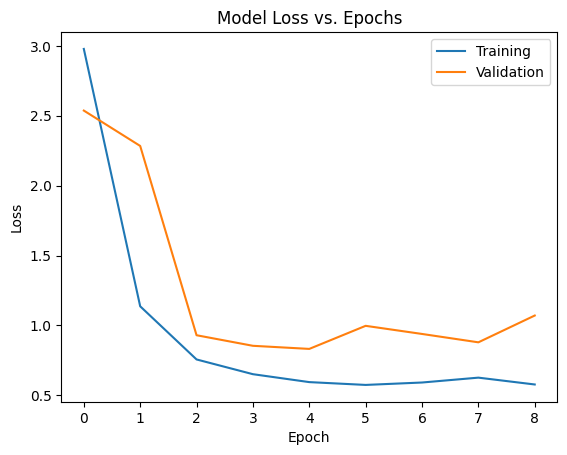

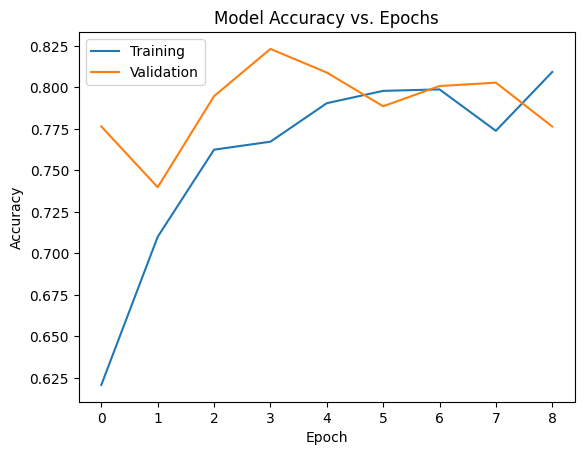

In [32]:
plot(history)

In [33]:
print_metrics(model)

Training Data Results:
Found 2286 files belonging to 5 classes.
Confusion Matrix:
tf.Tensor(
[[429   6  11  59   6]
 [ 17 307   7  10   3]
 [ 11   1 388  33   5]
 [  9   6   7 476   2]
 [ 11  27  53  25 377]], shape=(5, 5), dtype=int32)
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       511
           1       0.88      0.89      0.89       344
           2       0.83      0.89      0.86       438
           3       0.79      0.95      0.86       500
           4       0.96      0.76      0.85       493

    accuracy                           0.86      2286
   macro avg       0.87      0.87      0.87      2286
weighted avg       0.87      0.86      0.86      2286

Accuracy: 0.8648293963254593
----------------
Testing Data Results:
Confusion Matrix:
tf.Tensor(
[[83  1  5 20  0]
 [ 8 52  5  2  5]
 [ 1  2 76 11  3]
 [ 3  4  4 94  1]
 [ 3  8 12  9 72]], shape=(5, 5), dtype=int32)
Classification Report:
            

In [19]:
K.clear_session()
del model
gc.collect()

190687

#### EfficientNetB0

In [20]:
base_model_efficient = EfficientNetB0(include_top=True, weights='imagenet', input_shape=(224,224,3))
model, history = get_model(base_model_efficient, 'EfficientNetB0')

21848064/21834768 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________

Epoch 1/50
72/72 [==============================] - 49s 584ms/step - loss: 0.9545 - accuracy: 0.7218 - val_loss: 0.4263 - val_accuracy: 0.8496
Epoch 2/50
72/72 [==============================] - 38s 532ms/step - loss: 0.6088 - accuracy: 0.8049 - val_loss: 0.2802 - val_accuracy: 0.9126
Epoch 3/50
72/72 [==============================] - 37s 512ms/step - loss: 0.5069 - accuracy: 0.8290 - val_loss: 0.2368 - val_accuracy: 0.9248
Epoch 4/50
72/72 [==============================] - 39s 536ms/step - loss: 0.4345 - accuracy: 0.8469 - val_loss: 0.1915 - val_accuracy: 0.9309
Epoch 5/50
72/72 [==============================] - 38s 529ms/step - loss: 0.3974 - accuracy: 0.8640 - val_loss: 0.2590 - val_accuracy: 0.9329
Epoch 6/50
72/72 [==============================] - 38s 527ms/step - loss: 0.3815 - accuracy: 0.8631 - val_loss: 0.2696 - val_accuracy: 0.9126
Epoch 7/50
72/72 [==============================] - 37s 519ms/step - loss: 0.3986 - accuracy: 0.8653 - val_loss: 0.2628 - val_accuracy: 0.9248

In [ ]:
model = load_model('./EfficientNetB0')

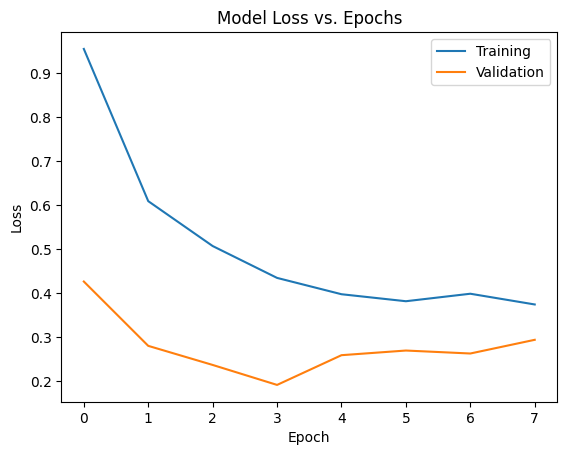

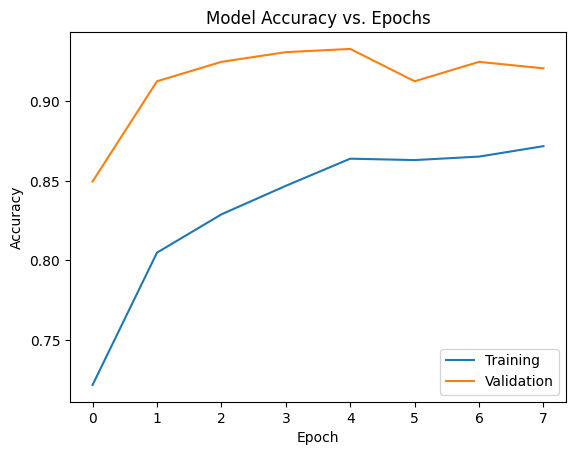

In [28]:
plot(history)

In [29]:
print_metrics(model)

Training Data Results:
Found 2286 files belonging to 5 classes.
Confusion Matrix:
tf.Tensor(
[[501   2   2   2   4]
 [  2 331   2   1   8]
 [  9   0 418   7   4]
 [ 14   1   2 472  11]
 [  3   4   7   4 475]], shape=(5, 5), dtype=int32)
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       511
           1       0.98      0.96      0.97       344
           2       0.97      0.95      0.96       438
           3       0.97      0.94      0.96       500
           4       0.95      0.96      0.95       493

    accuracy                           0.96      2286
   macro avg       0.96      0.96      0.96      2286
weighted avg       0.96      0.96      0.96      2286

Accuracy: 0.9610673665791776
----------------
Testing Data Results:
Confusion Matrix:
tf.Tensor(
[[105   0   0   1   3]
 [  0  64   0   3   5]
 [  3   1  86   1   2]
 [  6   0   0  98   2]
 [  1   4   1   0  98]], shape=(5, 5), dtype=int32)
Classifica

In [30]:
K.clear_session()
del model
gc.collect()

1631627

### Moving Average

In [69]:
L = 100
BATCH_SIZE = 32
CLASSES = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball', 'Image URLs']
train_dataset = tf.keras.utils.image_dataset_from_directory(IMAGES_PATH, seed=10, image_size=TARGET_SIZE, class_names=CLASSES)
VIDEOS_PATH = os.path.join(DATASET_FOLDER, 'Sport Videos')
classes = ['BaseballPitch', 'Basketball', 'Fencing', 'TennisSwing', 'VolleyballSpiking']
label_map = {label: i for i, label in enumerate(classes)}

img_augmentation = tf.keras.Sequential(
    [
        RandomCrop(height=TARGET_SIZE[0], width=TARGET_SIZE[1]),
        RandomZoom(height_factor=0.2),
        RandomRotation(factor=0.2),
        RandomFlip(),
        RandomContrast(factor=0.1),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        
    ]
)

augmented_train_dataset = train_dataset.map(lambda x, y: (img_augmentation(x, training=True), y))

Found 3279 files belonging to 6 classes.


In [70]:
def get_full_model(base_model, base_model_name, epochs, batch_size, augmented_train_dataset):
    # Freeze all layers in the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Get the output of the penultimate layer as input to the new fully connected layer
    x = base_model.layers[-2].output
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    predictions = Dense(5, activation='softmax')(x)

    # Create a new model with the output layer and the frozen pre-trained layers
    model = Model(inputs=base_model.input, outputs=predictions)
    print(model.summary())

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
    history = model.fit(augmented_train_dataset, batch_size=batch_size, epochs=epochs)
    filename = f'./{base_model_name}_full.pkl'
    pickle.dump(history.history, open(filename, 'wb'))
    model.save(f'./{base_model_name}_full')
    return model, history.history

def print_video_metrics(test_true, test_pred):
    cm = tf.math.confusion_matrix(labels=test_true, predictions=test_pred)
    print('Confusion Matrix:')
    print(cm)
    print('Classification Report:')
    print(classification_report(test_true, test_pred))
    print("Accuracy:", accuracy_score(test_true, test_pred))


#### EfficientNetB0

In [71]:
# using 10 epochs before previous section to prevent overfitting
base_model_efficient = EfficientNetB0(include_top=True, weights='imagenet', input_shape=(224,224,3))
model, history = get_full_model(base_model_efficient, 'EfficientNetB0', 10, BATCH_SIZE, augmented_train_dataset)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 224, 224, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_2[0][0]            
____________________________________________________________________________________________

Epoch 1/10
103/103 [==============================] - 59s 501ms/step - loss: 0.9136 - accuracy: 0.7389
Epoch 2/10
103/103 [==============================] - 52s 500ms/step - loss: 0.5569 - accuracy: 0.8188
Epoch 3/10
103/103 [==============================] - 52s 501ms/step - loss: 0.4473 - accuracy: 0.8435
Epoch 4/10
103/103 [==============================] - 55s 530ms/step - loss: 0.4414 - accuracy: 0.8536
Epoch 5/10
103/103 [==============================] - 53s 512ms/step - loss: 0.4152 - accuracy: 0.8588
Epoch 6/10
103/103 [==============================] - 52s 503ms/step - loss: 0.3970 - accuracy: 0.8564
Epoch 7/10
103/103 [==============================] - 52s 503ms/step - loss: 0.3971 - accuracy: 0.8658
Epoch 8/10
103/103 [==============================] - 53s 517ms/step - loss: 0.3989 - accuracy: 0.8591
Epoch 9/10
103/103 [==============================] - 54s 518ms/step - loss: 0.3747 - accuracy: 0.8707
Epoch 10/10
103/103 [==============================] - 52s 508ms/step - l

INFO:tensorflow:Assets written to: ./EfficientNetB0_full\assets


In [72]:
model = load_model('./EfficientNetB0_full')
history = pickle.load(open('EfficientNetB0_full.pkl', 'rb'))

In [74]:
all_predictions = {}

for index, video_class in enumerate(tqdm(os.listdir(VIDEOS_PATH))):
    if video_class not in classes: 
        continue
    print("Processing " + video_class)
    video_class_path = os.path.join(VIDEOS_PATH, video_class)
    class_preds = []
    frames = []
    for video in os.listdir(video_class_path):
        video_path = os.path.join(video_class_path, video)
        vc = cv2.VideoCapture(video_path)
        n_frames = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))
        if n_frames is None:
            continue
        frames_gap = n_frames//L 
        preds = []
        for i in range(0, n_frames, max(frames_gap, 1)):
            vc.set(cv2.CAP_PROP_POS_FRAMES, i)
            (grabbed, frame) = vc.read()
            if frame is None:
                continue
            frame = cv2.resize(frame, TARGET_SIZE).astype("float32")
            preds.append(model.predict(np.array([np.array(frame)]))[0])
        class_preds.append(np.argmax(np.array(preds).mean(axis=0)))
    all_predictions[video_class] = class_preds


  0%|          | 0/5 [00:00<?, ?it/s]

Processing BaseballPitch



 20%|██        | 1/5 [14:31<58:04, 871.12s/it]

Processing Basketball



 40%|████      | 2/5 [29:54<45:05, 901.76s/it]

Processing Fencing



 60%|██████    | 3/5 [43:14<28:30, 855.22s/it]

Processing TennisSwing



 80%|████████  | 4/5 [1:01:36<15:52, 952.77s/it]

Processing VolleyballSpiking


100%|██████████| 5/5 [1:12:17<00:00, 867.55s/it]


In [75]:
test_true = []
test_pred = []
for k, v in all_predictions.items():
    test_true = test_true + [label_map[k]]*len(v)
    test_pred = test_pred + v
print_video_metrics(test_true, test_pred)

Confusion Matrix:
tf.Tensor(
[[108   0   8  34   0]
 [  0   2  56  59  20]
 [  3   0 108   0   0]
 [ 25   0  13 129   0]
 [  0   0  80   3  33]], shape=(5, 5), dtype=int32)
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.72      0.76       150
           1       1.00      0.01      0.03       137
           2       0.41      0.97      0.57       111
           3       0.57      0.77      0.66       167
           4       0.62      0.28      0.39       116

    accuracy                           0.56       681
   macro avg       0.68      0.55      0.48       681
weighted avg       0.69      0.56      0.49       681

Accuracy: 0.5580029368575624


In [48]:
K.clear_session()
del model
gc.collect()

1615065

#### VGG16

In [81]:
base_model_VGG16 = VGG16(include_top=True, weights='imagenet', input_shape=(224,224,3))
model, history = get_full_model(base_model_VGG16, 'VGG16', 10, BATCH_SIZE, augmented_train_dataset)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

INFO:tensorflow:Assets written to: ./VGG16_full\assets


In [82]:
model = load_model('./VGG16_full')
history = pickle.load(open('VGG16_full.pkl', 'rb'))

In [83]:
all_predictions = {}

for index, video_class in enumerate(tqdm(os.listdir(VIDEOS_PATH))):
    if video_class not in classes: 
        continue
    print("Processing " + video_class)
    video_class_path = os.path.join(VIDEOS_PATH, video_class)
    class_preds = []
    frames = []
    for video in os.listdir(video_class_path):
        video_path = os.path.join(video_class_path, video)
        vc = cv2.VideoCapture(video_path)
        n_frames = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))
        if n_frames is None:
            continue
        frames_gap = n_frames//L 
        preds = []
        for i in range(0, n_frames, max(frames_gap, 1)):
            vc.set(cv2.CAP_PROP_POS_FRAMES, i)
            (grabbed, frame) = vc.read()
            if frame is None:
                continue
            frame = cv2.resize(frame, TARGET_SIZE).astype("float32")
            preds.append(model.predict(np.array([np.array(frame)]))[0])
        class_preds.append(np.argmax(np.array(preds).mean(axis=0)))
    all_predictions[video_class] = class_preds


  0%|          | 0/5 [00:00<?, ?it/s]

Processing BaseballPitch



 20%|██        | 1/5 [17:30<1:10:02, 1050.58s/it]

Processing Basketball



 40%|████      | 2/5 [36:26<55:02, 1100.67s/it]  

Processing Fencing



 60%|██████    | 3/5 [53:45<35:45, 1072.79s/it]

Processing TennisSwing



 80%|████████  | 4/5 [1:18:03<20:24, 1224.87s/it]

Processing VolleyballSpiking


100%|██████████| 5/5 [1:32:48<00:00, 1113.77s/it]


In [84]:
test_true = []
test_pred = []
for k, v in all_predictions.items():
    test_true = test_true + [label_map[k]]*len(v)
    test_pred = test_pred + v
print_video_metrics(test_true, test_pred)

Confusion Matrix:
tf.Tensor(
[[127   0  21   2   0]
 [  9   3  64  35  26]
 [  3   0 106   0   2]
 [ 50   1  58  43  15]
 [  2   0  67  13  34]], shape=(5, 5), dtype=int32)
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.85      0.74       150
           1       0.75      0.02      0.04       137
           2       0.34      0.95      0.50       111
           3       0.46      0.26      0.33       167
           4       0.44      0.29      0.35       116

    accuracy                           0.46       681
   macro avg       0.53      0.47      0.39       681
weighted avg       0.54      0.46      0.39       681

Accuracy: 0.45961820851688695


In [85]:
K.clear_session()
del model
gc.collect()

354578